In [86]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

from scipy.optimize import minimize

In [ ]:
num_qubits = 4
initial_states = []

for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)  # Flip one qubit to prepare |φ_k⟩
    initial_states.append(qc)

## Hamiltonian for transverse ising model

Hamiltonian is given by $H = a \sum_{i=1}^{N}X_i + J \sum_{\langle i,j \rangle}^{N} Z_i Z_j$

In [ ]:
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]

    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)


hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

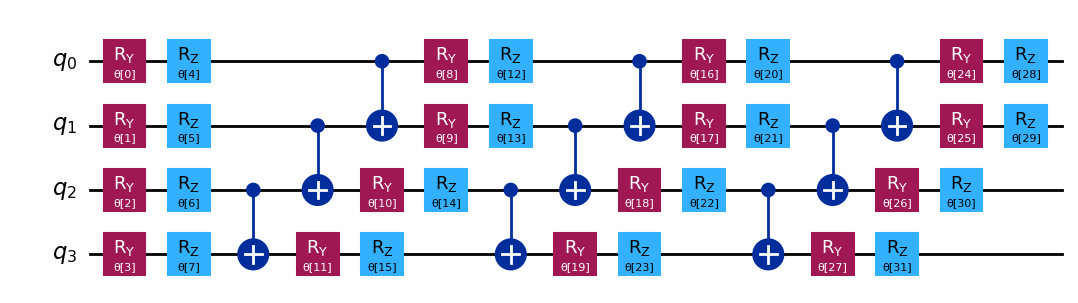

In [53]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(hamiltonian.num_qubits).decompose()

ansatz.draw("mpl")

In [79]:
weights = np.arange(num_qubits, 0, -1)

print(weights)

[4 3 2 1]


In [39]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

## Weighted sum of expectation values for the cost function
$\text{SSVQE\_Cost}(\theta) = \sum_k w_k \langle \psi_k(\theta) | H | \psi_k(\theta) \rangle$

In [ ]:
def ssvqe_cost_func(params, ansatz, hamiltonian, estimator, initial_states, weights):
    pubs = []

    for init_state in initial_states:
        full_circuit = init_state.compose(ansatz)
        pubs.append((full_circuit, [hamiltonian], [params]))

    result = estimator.run(pubs=pubs).result()
    energies = [r.data.evs[0] for r in result]

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(weighted_energy)
    print(
        f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}, Energies: {energies}"
    )

    return weighted_energy

In [70]:
estimator = AerEstimator()
estimator.options.shots = 1000000

In [87]:
params_init = np.random.rand(ansatz.num_parameters)

result = minimize(
    ssvqe_cost_func,
    params_init,
    args=(ansatz, hamiltonian, estimator, initial_states, weights),
    method="COBYLA",
    options={"maxiter": 100},
)

[Iter 901] Cost: 9.290083, Energies: [np.float64(2.1491853433647057), np.float64(-0.7635266322633448), np.float64(0.7616572920704985), np.float64(1.4606067502191455)]
[Iter 902] Cost: 7.755303, Energies: [np.float64(1.517596976886853), np.float64(-0.5138168019845375), np.float64(0.9166079655699142), np.float64(1.3931499414541306)]
[Iter 903] Cost: 4.725949, Energies: [np.float64(0.6562219187700772), np.float64(-0.039438066299407715), np.float64(0.6175775675364764), np.float64(0.9842201231537671)]
[Iter 904] Cost: 3.291492, Energies: [np.float64(0.6817735568409994), np.float64(-0.5912929239105317), np.float64(0.6876405354425852), np.float64(0.9629957913580576)]
[Iter 905] Cost: 5.388260, Energies: [np.float64(1.3963079229483832), np.float64(-0.7647631320116294), np.float64(0.8808566564173701), np.float64(0.3356047849619089)]
[Iter 906] Cost: 2.585167, Energies: [np.float64(0.33051125536321624), np.float64(-0.6464852330568652), np.float64(0.6601193569313495), np.float64(1.88233926203291)

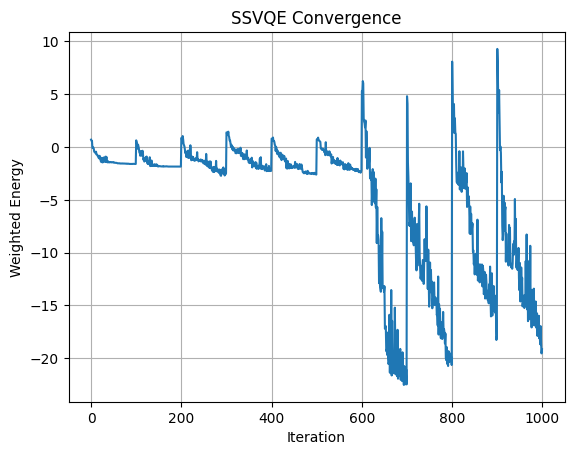

In [88]:
plt.plot(cost_history_dict["cost_history"])
plt.xlabel("Iteration")
plt.ylabel("Weighted Energy")
plt.title("SSVQE Convergence")
plt.grid()
plt.show()